In [1]:
import os
from multiprocessing import Pool

import networkx as nx
import numpy as np
from karateclub import Graph2Vec
from ogb.graphproppred import Evaluator, GraphPropPredDataset
from sklearn import svm
from tqdm import tqdm

In [ ]:
import os
from multiprocessing import Pool

import networkx as nx
import numpy as np
from karateclub import Graph2Vec
from ogb.graphproppred import Evaluator, GraphPropPredDataset
from sklearn import svm
from tqdm import tqdm

In [2]:
feature_names = [
    'atomic_num',
    'chirality',
    'degree',
    'formal_charge',
    'num_h',
    'num_rad_e',
    'hybridization',
    'is_aromatic',
    'is_in_ring',
]

In [3]:
def graph_dict_to_nx_graph(
    graph_dict: dict
):
    """
    Constructs a NetworkX graph object from the given graph dictionary.

    Args:
        graph_dict: A dictionary representing a graph, with the following keys:
            - 'num_nodes': The number of nodes in the graph.
            - 'node_feat': A list of node features, with one feature vector per node.
            - 'edge_index': An edge index array of shape (2, E), where E is the number of edges.
            - 'edge_feat': A list of edge features, with one feature vector per edge.

    Returns:
        A NetworkX graph object with nodes and edges corresponding to the input graph.
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(graph_dict['num_nodes']))

    for node_number, features in enumerate(graph_dict['node_feat']):
        graph.add_node(node_number, feature=features)

    # change shape from (2, E) to (E, 2)
    edge_list = np.transpose(graph_dict['edge_index'])
    for node_number, (from_node, to_node) in enumerate(edge_list):
        features = graph_dict['edge_feat'][node_number]
        graph.add_edge(from_node, to_node, feature=features)

    return graph

In [4]:
def edges_to_nodes(
    graph:      nx.Graph
) -> nx.Graph:
    """
    Generates a new graph where each edge (u, v) is replaced with two edges
    (u, uv), (uv, v) and a new node uv. The attributes of the edge are
    copied to the new edge. This method may help if a graph embedding does
    not not support edge attributes.
    """
    new_graph = nx.Graph()
    max_node = max(list(graph.nodes))

    for node in nx.nodes(graph):
        new_graph.add_node(node)

        features = graph.nodes[node]
        new_graph.nodes[node].update(features)

    for u, v in nx.edges(graph):
        max_node += 1

        new_graph.add_node(max_node)
        new_graph.add_edge(u, max_node)
        new_graph.add_edge(max_node, v)

        features = graph.edges[u, v]
        new_graph.nodes[max_node].update(features)

    return graph  # new_graph

In [5]:
def get_shortest_paths(graph):
    shortest_paths = []

    shortest_path_dict = dict(nx.all_pairs_shortest_path(graph))

    for source in graph.nodes:
        for target in graph.nodes:
            if nx.has_path(graph, source, target):
                shortest_path = shortest_path_dict[source][target]
                if len(shortest_path) >= 2:
                    shortest_paths.append(shortest_path)

    return shortest_paths

In [6]:
def substitute_nodes_with_features(shortest_path, graph):
    feat_to_include = [0]
    path_str = []
    for node_id in shortest_path:
        for j, feat in enumerate(feat_to_include):
            path_str.append(f'{j}_{graph.nodes[node_id]["feature"][feat]}')
    path_str = ' '.join(path_str)
    return path_str

In [7]:
def write_paths_to_file(dataset):
    start_line = 1
    line = 1
    with open('rows.txt', 'w') as f_rows, open('shortest_paths.txt', 'w') as f_paths:
        for i, (graph_dict, label) in enumerate(tqdm(dataset)):
            graph = graph_dict_to_nx_graph(graph_dict)
            shortest_paths = get_shortest_paths(graph)
            for shortest_path in shortest_paths:
                path_str = substitute_nodes_with_features(shortest_path, graph)
                f_paths.write(path_str + " STOP ")
                line += 1
            f_paths.write("\n")
            f_rows.write(str(start_line) + " " + str(line-1) + '\n')
            start_line = line

In [8]:
dataset_name = 'ogbg-molfreesolv'
dataset = GraphPropPredDataset(name=dataset_name)
split_idx = dataset.get_idx_split()

# rows are inclusive
write_paths_to_file(dataset)

100%|██████████| 642/642 [00:00<00:00, 722.88it/s]


In [9]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(corpus_file='shortest_paths.txt')

train_X = np.array([model.dv[x] for x in split_idx['train']])
train_y = np.array([dataset[x][1] for x in split_idx['train']]).ravel()

test_X = np.array([model.dv[x] for x in split_idx['test']])
test_y = np.array([dataset[x][1] for x in split_idx['test']]).ravel()

valid_X = np.array([model.dv[x] for x in split_idx['valid']])
valid_y = np.array([dataset[x][1] for x in split_idx['valid']]).ravel()

train_X.shape, train_y.shape

((513, 100), (513,))

In [22]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=1000)
reg.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000)

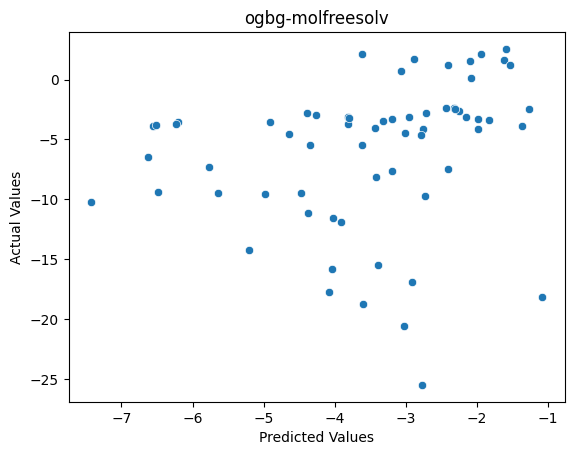

In [24]:
import seaborn as sns

predicted_valid_y = reg.predict(valid_X)
scatter_plot = sns.scatterplot(x=predicted_valid_y, y=valid_y)
scatter_plot.set(xlabel ="Predicted Values", ylabel="Actual Values", title=dataset_name)
scatter_plot.figure.savefig('dataset_name.png')